# Autoencoder

This notebook implements an autoencoder and a variational autoencoder model in PyTorch.
We will train the moels to reconstruct images from the MNIST data set.
The sampling images of the two models will also be compared. 



In [82]:
import os
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

## Hyperparameters

In [83]:
num_epochs = 10
batch_size = 128
learning_rate = 1e-2
latent_dim = 3

## Dataloader and utilites

In [84]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

dataset = MNIST(root='./data',train=True,download=True,transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Network Models


In [85]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), nn.Linear(64, 12), nn.ReLU(True), nn.Linear(12, latent_dim))
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), nn.Linear(128, 28 * 28), nn.Tanh())

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x
    
    def decode(self, z):
        x = self.decoder(z)
        return x

## Training Loop

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


epoch [1/1], loss:0.5176


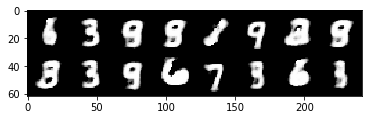

Training finished


In [94]:
ae = autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    ae.parameters(), lr=learning_rate, weight_decay=1e-5)

for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.view(img.size(0), -1)

        # ===================forward=====================
        output = ae(img)
        loss = criterion(output, img)
        
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item()))
    

    images = output.view(output.shape[0], 1,28, 28).detach()
    imshow(torchvision.utils.make_grid(images[:16]))
    
print("Training finished")

## Autoencoder as a Generative Model


After training, you can see that the quality of the reconstruction from autoencoder is very good. However, as well as reproducing the training items, we also want to be able to use the decoder to generate new items which are of a similar "style" to the training items.

In other words, we want to be able to choose latent variables z from a standard Normal distribution $p(z)$, feed these values of z to the decoder, and have it produce a new item x which is somehow similar to the training items. Since there the distribution of the latent variable of autoencoder is not forced to be close to Gaussian distribution, sampling from a Gaussian distribution and then feed $z$ to the decoder would not give us good generated images in terms of quality and variety. Lets see some examples.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


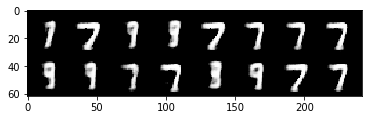

In [96]:
with torch.no_grad():
    ae.eval()
    noise = torch.randn(batch_size, latent_dim)
    generated_images = ae.decode(noise)

    images = generated_images.view(batch_size, 1,28, 28).detach()
    imshow(torchvision.utils.make_grid(images[:16]))

## Variational Autoencoder
To solve the aformentioned issue, Variational Autoencoder has been proposed. You can see more details in "Auto-Encoding Variational Bayes" (2014, D.P. Kingma et. al.).

## Model
Unlike autoencoder which encode images into latent variables directly, VAE instead outputs a set of mean and variance to represent a Gaussian distribtuion. Thus, we need a special designed network architecture.  

In [89]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, latent_dim)
        self.fc22 = nn.Linear(400, latent_dim)
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


## Loss Function

VAE also has a different loss function compared with autoencoder. Specifically, it not only minimize the reconstruction loss but also force the latent distribution to be close to a standard Gaussian using the KL-divergence.

In [90]:
reconstruction_function = nn.MSELoss(reduction='sum')


def loss_function(recon_x, x, mu, logvar):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    BCE = reconstruction_function(recon_x, x)  # mse loss
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return BCE + KLD



## Training Loop

epoch [1/1], loss:50169.0234


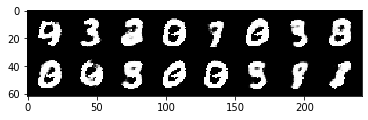

Finished Training


In [97]:
# Create model
vae = VAE()
optimizer = torch.optim.Adam(vae.parameters(), lr=learning_rate)


for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    for batch_idx, data in enumerate(dataloader):
        img, _ = data
        img = img.view(img.size(0), -1)
#         if torch.cuda.is_available():
#             img = img.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(img)
        loss = loss_function(recon_batch, img, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, loss.item()))
    
    images = recon_batch.view(recon_batch.shape[0], 1,28, 28).detach()
    imshow(torchvision.utils.make_grid(images[:16]))

print("Finished Training")

## Sampling with VAE

Let's check the sampling images of VAE, we also show the generated images of the autoencoder model for comparison. (You can rerun the following code cell for multiple times to see different samples)

Generated images from VAE:


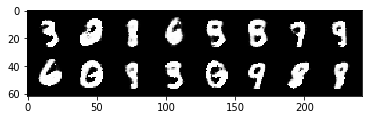

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Generated images from autoencoder:


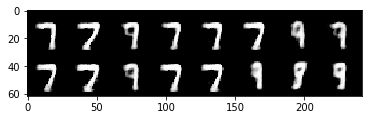

In [98]:
with torch.no_grad():
    vae.eval()
    ae.eval()
    
    noise = torch.randn(batch_size, latent_dim)
    generated_images = vae.decode(noise)

    
    images = generated_images.view(generated_images.shape[0], 1,28, 28).detach()
    
    print("Generated images from VAE:")
    imshow(torchvision.utils.make_grid(images[:16]))
    
    generated_images = ae.decode(noise)

    
    images = generated_images.view(generated_images.shape[0], 1,28, 28).detach()
    
    print("Generated images from autoencoder:")
    imshow(torchvision.utils.make_grid(images[:16]))
    

You can see now the diversity of the images is much better (the learned distribution is more close to the data distribution). There are many more generative models in the literature, you can check further readings in the week6 autoencoder slides.